In [1]:
# Import packages

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import math

import wf_psf as wf
import wf_psf.SimPSFToolkit as SimPSFToolkit
import wf_psf.utils as wf_utils
import wf_psf.tf_mccd_psf_field as tf_mccd_psf_field
import wf_psf.tf_psf_field as tf_psf_field
import wf_psf.metrics as wf_metrics
import wf_psf.train_utils as wf_train_utils
import wf_psf.script_utils as wf_script_utils

# Plot style & colormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

# Pre-defined colormap
top = mpl.colormaps['Oranges_r'].resampled(128)
bottom = mpl.colormaps['Blues'].resampled(128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


/Users/tl255879/miniconda3/envs/wf_tools/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [42]:

# %matplotlib inline
params = {
    "font.size": 18,
    "legend.fontsize": 18,
    "legend.frameon": False,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "figure.figsize": (7, 5),
    "xtick.top": True,
    "axes.unicode_minus": False,
    "ytick.right": True,
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.major.pad": 8,
    "xtick.major.size": 8,
    "xtick.minor.size": 4,
    "ytick.major.size": 8,
    "ytick.minor.size": 4,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "axes.linewidth": 1.5,
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "cmr10",
    "mathtext.fontset": "cm",
    "axes.formatter.use_mathtext": True,  # needed when using cm=cmr10 for normal text
}


mpl.rcParams.update(params)




# Model parameters

In [23]:

args = {
    'id_name': '_wf_PR_NewPRoj_12_cycles_v2' ,
    'suffix_id_name': 'v2' ,
    'base_id_name': '_wf_PR_NewPRoj_12_cycles_' ,
    'eval_only_param': False ,
    'total_cycles': 12 ,
    'saved_cycle': 'cycle12' ,
    'reset_dd_features': True ,
    'eval_only_param': False ,
    'project_dd_features': True ,
    'd_max': 2 ,
    'n_zernikes': 45 ,
    'save_all_cycles': True ,
    'n_bins_lda': 8,
    'n_bins_gt': 8,
    'output_dim': 32,
    'batch_size': 32,
    'oversampling_rate': 3.,
    'output_q': 3.,
    'sed_sigma': 0.,
    'x_lims': [0, 1e3],
    'y_lims': [0, 1e3],
    'sed_interp_kind': 'linear',
    'interp_pts_per_bin': 0,
    'extrapolate': True,
    'opt_stars_rel_pix_rmse': True ,
    'eval_mono_metric_rmse': False,
    'eval_opd_metric_rmse': True,
    'eval_train_shape_sr_metric_rmse': True,
    'pupil_diameter': 256 ,
    'n_epochs_param_multi_cycle': "0" ,
    'n_epochs_non_param_multi_cycle': "75" ,
    'l_rate_non_param_multi_cycle': "0.1" ,
    'l_rate_param_multi_cycle': "0" ,
    'l_rate_param': None,
    'l_rate_non_param': None,
    'n_epochs_param': None,
    'n_epochs_non_param': None,
    'model': 'poly' ,
    'model_eval': 'poly' ,
    'cycle_def': 'complete' ,
    'gt_n_zernikes': 45 ,
    'd_max_nonparam': 5 ,
    'saved_model_type': 'external' ,
    'use_sample_weights': True ,
    'l2_param': 0. ,
    'interpolation_type': 'none' ,
    'eval_batch_size': 16 ,
    'train_opt': True ,
    'eval_opt': True ,
    'plot_opt': True ,
    'dataset_folder': '/Users/tl255879/Documents/research/projects/wf-projects/phase-retrieval-paper/v1_trained_models/paper_output_v1/dataset/',
    'test_dataset_file': 'test_Euclid_res_id_010_8_bins.npy',
    'train_dataset_file': 'train_Euclid_res_2000_TrainStars_id_010_8_bins.npy',
    'base_path': '/Users/tl255879/Documents/research/projects/wf-projects/phase-retrieval-paper/v1_trained_models/output_v1/',
    'metric_base_path': '/Users/tl255879/Documents/research/projects/wf-projects/phase-retrieval-paper/v1_trained_models/output_v1/metrics/',
    'chkp_save_path': '/Users/tl255879/Documents/research/projects/wf-projects/phase-retrieval-paper/v1_trained_models/paper_output_v1/chkp/chkp_callback_poly_wf_PR_NewPRoj_12_cycles_v0_cycle%d',
    'plots_folder': 'plots/' ,
    'model_folder': 'chkp/' ,
    'log_folder': 'log-files/' ,
    'optim_hist_folder': 'optim-hist/' ,
    'star_numbers': 1 ,
}

In [48]:

save_dir = './../plots/WFE_plots/'
plot_results = True


In [25]:
## Prepare the inputs
# Generate Zernike maps
zernikes = wf_utils.zernike_generator(
    n_zernikes=args['n_zernikes'], wfe_dim=args['pupil_diameter']
)
# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))
for it in range(len(zernikes)):
    np_zernike_cube[it, :, :] = zernikes[it]
np_zernike_cube[np.isnan(np_zernike_cube)] = 0
tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)
print('Zernike cube:')
print(tf_zernike_cube.shape)

# Generate ground truth Zernike maps
zernikes_gt = wf_utils.zernike_generator(
    n_zernikes=args['gt_n_zernikes'], wfe_dim=args['pupil_diameter']
)
# Now as cubes
np_zernike_cube_gt = np.zeros((len(zernikes_gt), zernikes_gt[0].shape[0], zernikes_gt[0].shape[1]))
for it in range(len(zernikes_gt)):
    np_zernike_cube_gt[it, :, :] = zernikes_gt[it]
np_zernike_cube_gt[np.isnan(np_zernike_cube_gt)] = 0
tf_zernike_cube_gt = tf.convert_to_tensor(np_zernike_cube_gt, dtype=tf.float32)
print('Ground truth Zernike cube:')
print(tf_zernike_cube_gt.shape)

Zernike cube:
(45, 256, 256)
Ground truth Zernike cube:
(45, 256, 256)


In [26]:
## Generate initializations
# Prepare np input
simPSF_np = SimPSFToolkit(
    zernikes,
    max_order=args['n_zernikes'],
    pupil_diameter=args['pupil_diameter'],
    output_dim=args['output_dim'],
    oversampling_rate=args['oversampling_rate'],
    output_Q=args['output_q']
)
simPSF_np.gen_random_Z_coeffs(max_order=args['n_zernikes'])
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)
# Obscurations
obscurations = simPSF_np.generate_pupil_obscurations(N_pix=args['pupil_diameter'], N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.complex64)


## Ground truth WFE

In [27]:
# Select any star from the 2000 test stars and generate GT WFE
test_star = 188
test_dataset = np.load(args['dataset_folder']+args['test_dataset_file'], allow_pickle=True)[()]
pos = test_dataset['positions'][test_star:test_star+1,:]
# ignore first order
param_opd_maps_GT = tf.tensordot(
    tf_zernike_cube_gt[1:],
    tf.constant(test_dataset['zernike_coef'][test_star,1:,0],dtype=tf.float32),
    axes=[0,0]
)


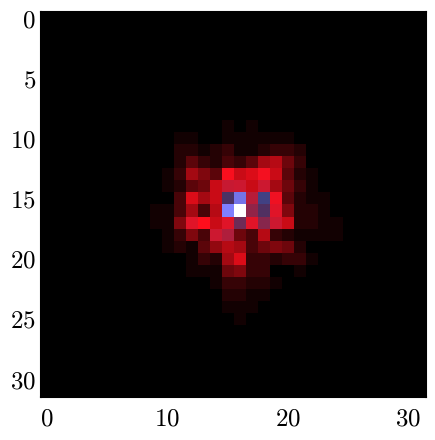

In [28]:
SR_GT_test_star = test_dataset['super_res_stars'][test_star:test_star+1,:,:]

In [29]:
input_sed = test_dataset['SEDs'][test_star:test_star+1,:,:]

packed_SED_data = [
    wf_utils.generate_packed_elems(_sed, simPSF_np, n_bins=args['n_bins_lda'])
    for _sed in input_sed
]
# Prepare the inputs for the training
tf_packed_SED_data = tf.convert_to_tensor(packed_SED_data, dtype=tf.float32)
tf_packed_SED_data = tf.transpose(tf_packed_SED_data, perm=[0, 2, 1])

tf_pos = tf.convert_to_tensor(pos, dtype=tf.float32)

psf_input = [tf_pos, tf_packed_SED_data]


In [31]:
weights_paths = args['chkp_save_path']

tf_semiparam_field = tf_psf_field.TF_SemiParam_field(
        zernike_maps=tf_zernike_cube,
        obscurations=tf_obscurations,
        batch_size=args['batch_size'],
        output_Q=1,  # args['output_q'],
        d_max_nonparam=args['d_max_nonparam'],
        l2_param=args['l2_param'],
        output_dim=64, # args['output_dim'],
        n_zernikes=args['n_zernikes'],
        d_max=args['d_max'],
        x_lims=args['x_lims'],
        y_lims=args['y_lims']
    )
# Load the model's weights and project
tf_semiparam_field.load_weights(weights_paths % (12)).expect_partial()
tf_semiparam_field = wf.tf_psf_field.build_PSF_model(
    tf_semiparam_field,
    optimizer=tf.keras.optimizers.legacy.Adam(
            learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False
        ),
    loss=None,
    metrics=None
)

poly_psf = tf_semiparam_field(psf_input)



Printing random seed
None
Printing random seed
None


## Plot pixel PSF

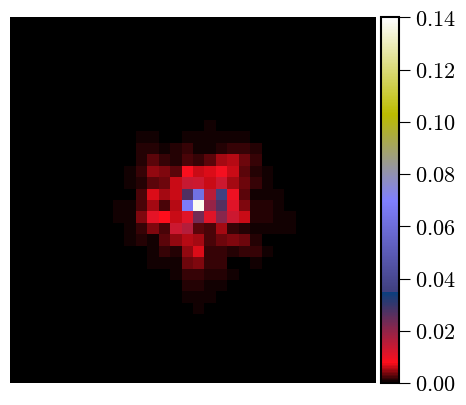

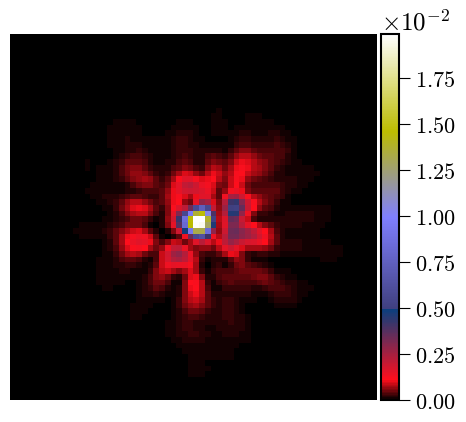

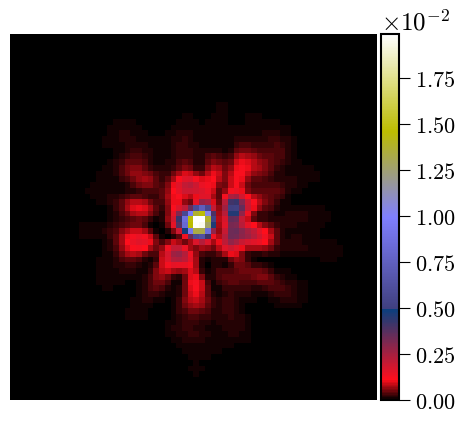

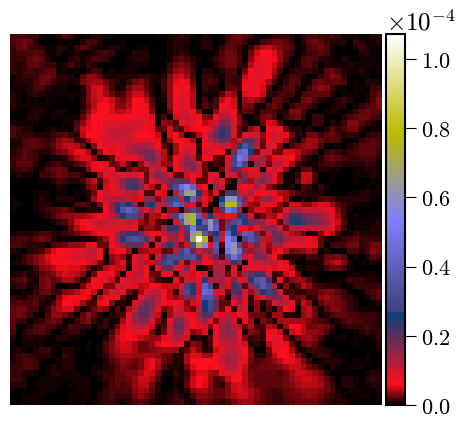

In [179]:

plot_style = {
    'axes.formatter.use_mathtext': True,
    'text.usetex': False,
}
mpl.rcParams.update(plot_style)

cbar_ticks_size = 16
offset_text_size = 18

mystar = test_dataset['stars'][test_star,:,:]


fig = plt.figure(figsize=(5,5))
axs = plt.gca()
im = axs.imshow(mystar, cmap='gist_stern', vmin=0, vmax=0.14)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)#, extend='both')
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=cbar_ticks_size, direction="out")
# cbar.formatter.set_powerlimits((0, 0))
# cbar.ax.yaxis.offsetText.set(size=offset_text_size)
# cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()
axs.set_xticks([])
axs.set_yticks([])
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
plt.tight_layout()
if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'polyPSF_GT_euclid_resolution.pdf'),
        bbox_inches='tight',
        dpi=200
    )
plt.show()






fig = plt.figure(figsize=(5,5))
axs = plt.gca()
im = axs.imshow(poly_psf[0], cmap='gist_stern', vmin=0, vmax=0.0199)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)#, extend='both')
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=cbar_ticks_size, direction="out")
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.offsetText.set(size=offset_text_size)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()
axs.set_xticks([])
axs.set_yticks([])
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
plt.tight_layout()
if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'polyPSF_reconstruction.pdf'),
        bbox_inches='tight',
        dpi=200
    )
plt.show()


fig = plt.figure(figsize=(5,5))
axs = plt.gca()
im = axs.imshow(SR_GT_test_star[0], cmap='gist_stern', vmin=0, vmax=0.0199)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)#, extend='both')
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=cbar_ticks_size, direction="out")
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.offsetText.set(size=offset_text_size)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()
axs.set_xticks([])
axs.set_yticks([])
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
plt.tight_layout()
if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'polyPSF_GT.pdf'),
        bbox_inches='tight',
        dpi=200
    )
plt.show()


fig = plt.figure(figsize=(5,5))
axs = plt.gca()
im = axs.imshow(np.abs(SR_GT_test_star[0] - poly_psf[0]), cmap='gist_stern', vmin=0)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)#, extend='both')
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=cbar_ticks_size, direction="out")
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.offsetText.set(size=offset_text_size)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()
axs.set_xticks([])
axs.set_yticks([])
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
plt.tight_layout()
if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'polyPSF_reconstruction_error.pdf'),
        bbox_inches='tight',
        dpi=200
    )
plt.show()




## Load the models and generate the WFE maps

Warning: This step can be time consuming! 

In [34]:
weights_paths = args['chkp_save_path']
WFE_list = []
WFE_non_param_list = []
WFE_proj_non_param_list = []

for cycle_idx in range(args['total_cycles']):
    print('Working on cycle: ', cycle_idx)
    tf_semiparam_field = tf_psf_field.TF_SemiParam_field(
            zernike_maps=tf_zernike_cube,
            obscurations=tf_obscurations,
            batch_size=args['batch_size'],
            output_Q=args['output_q'],
            d_max_nonparam=args['d_max_nonparam'],
            l2_param=args['l2_param'],
            output_dim=args['output_dim'],
            n_zernikes=args['n_zernikes'],
            d_max=args['d_max'],
            x_lims=args['x_lims'],
            y_lims=args['y_lims']
        )
    # Load the model's weights and project
    tf_semiparam_field.load_weights(weights_paths % (cycle_idx+1)).expect_partial()


    # Non parametric WFE
    nonparam_opd_maps = tf_semiparam_field.tf_np_poly_opd(pos)
    WFE_non_param_list.append(nonparam_opd_maps)  

    # Project DD features to param part
    tf_semiparam_field.project_DD_features(tf_zernike_cube)

    # After projection
    nonparam_proj_opd_maps = tf_semiparam_field.tf_np_poly_opd(pos)
    WFE_proj_non_param_list.append(nonparam_proj_opd_maps)
    
    # Parametric WFE
    zernike_coeffs = tf_semiparam_field.tf_poly_Z_field(pos)
    zernike_coeffs = np.array(zernike_coeffs)
    zernike_coeffs[0,0,0,0] = 0
    param_opd_maps = tf_semiparam_field.tf_zernike_OPD(zernike_coeffs)
    
    WFE_list.append(param_opd_maps)   
    

Working on cycle:  0
Printing random seed
None
Printing random seed
None
Working on cycle:  1
Printing random seed
None
Printing random seed
None
Working on cycle:  2
Printing random seed
None
Printing random seed
None
Working on cycle:  3
Printing random seed
None
Printing random seed
None
Working on cycle:  4
Printing random seed
None
Printing random seed
None
Working on cycle:  5
Printing random seed
None
Printing random seed
None
Working on cycle:  6
Printing random seed
None
Printing random seed
None
Working on cycle:  7
Printing random seed
None
Printing random seed
None
Working on cycle:  8
Printing random seed
None
Printing random seed
None
Working on cycle:  9
Printing random seed
None
Printing random seed
None
Working on cycle:  10
Printing random seed
None
Printing random seed
None
Working on cycle:  11
Printing random seed
None
Printing random seed
None


In [47]:
np.max(np.abs(WFE_list))

0.59940606

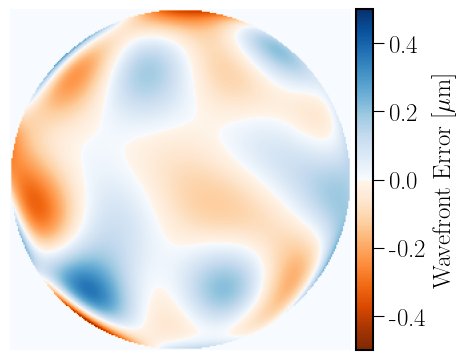

In [74]:
plot_style = {
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
}

mpl.rcParams.update(plot_style)

vmax=0.5
cbar_ticks_size = 18

fig = plt.figure(figsize=(5,5))
axs = plt.gca()
plt_im = axs.imshow(param_opd_maps_GT, cmap=newcmp, vmax=vmax, vmin=-vmax)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(plt_im, cax=cax)
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=cbar_ticks_size, direction="out")
cbar.set_label(r'Wavefront Error [$\mu$m]')
# axs.set_yticks([]);axs.set_xticks([]) # Use this if you want to have the black border over the image
axs.axis('off')
plt.tight_layout()
if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'GT_WFE_PSF.pdf'),
        bbox_inches='tight',
        dpi=200
    )
plt.show()



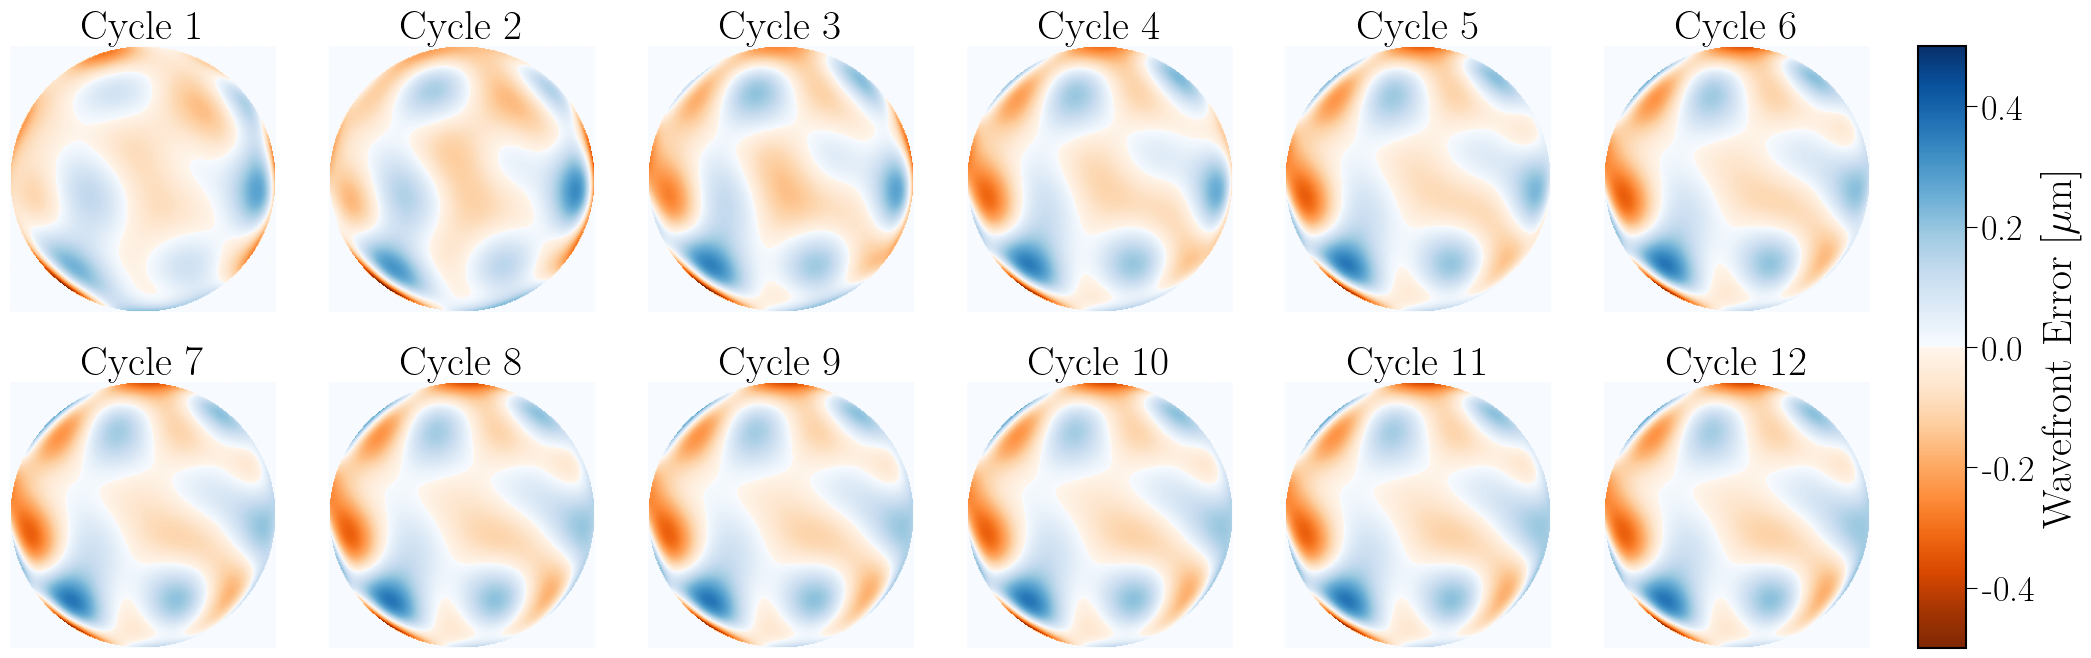

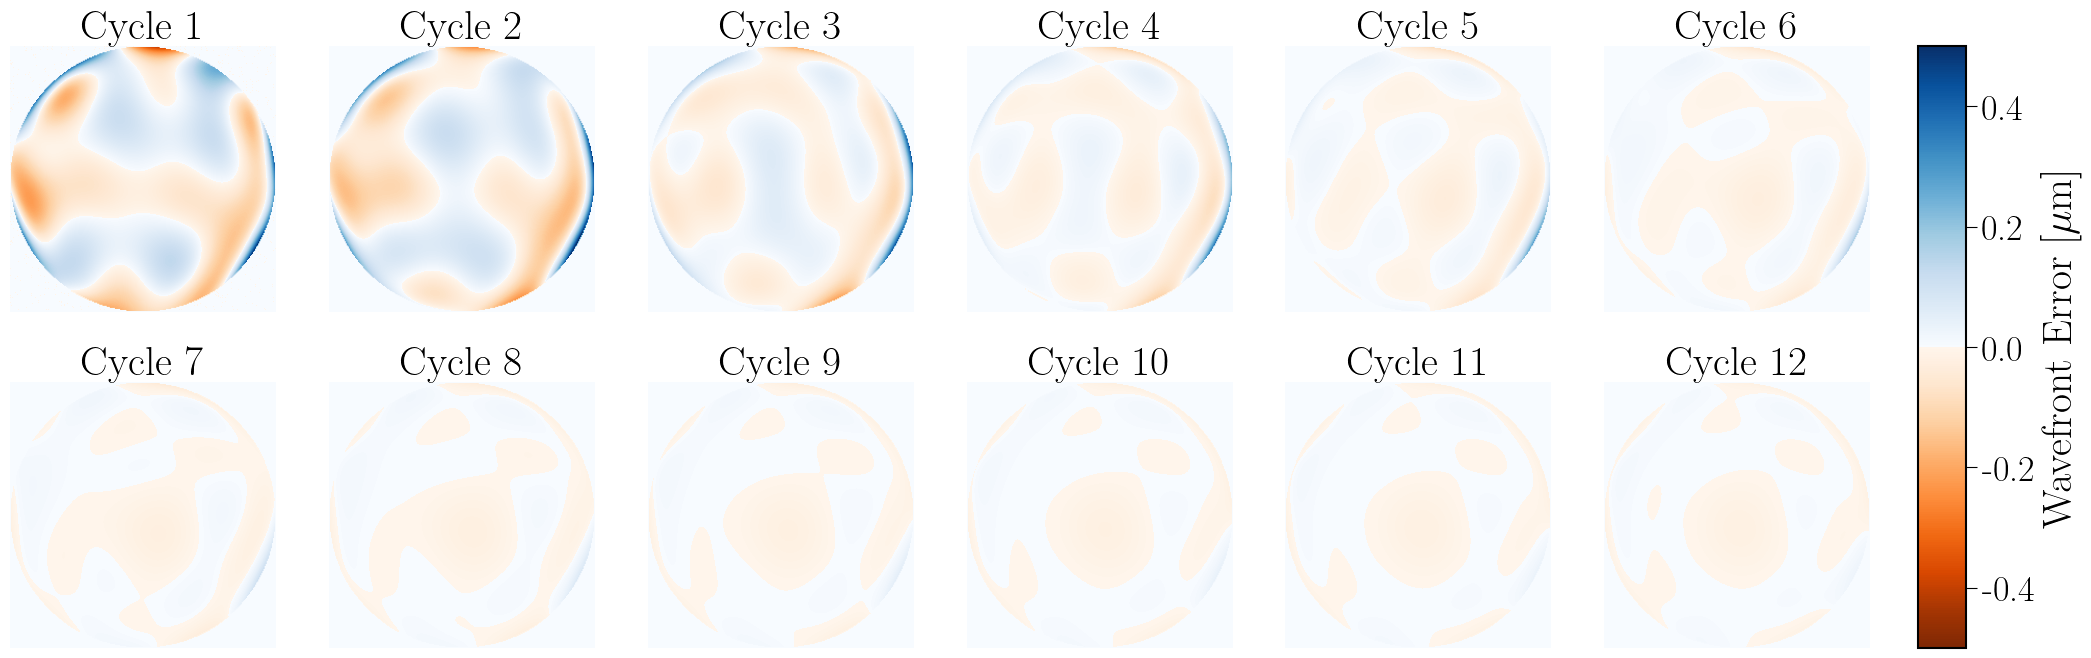

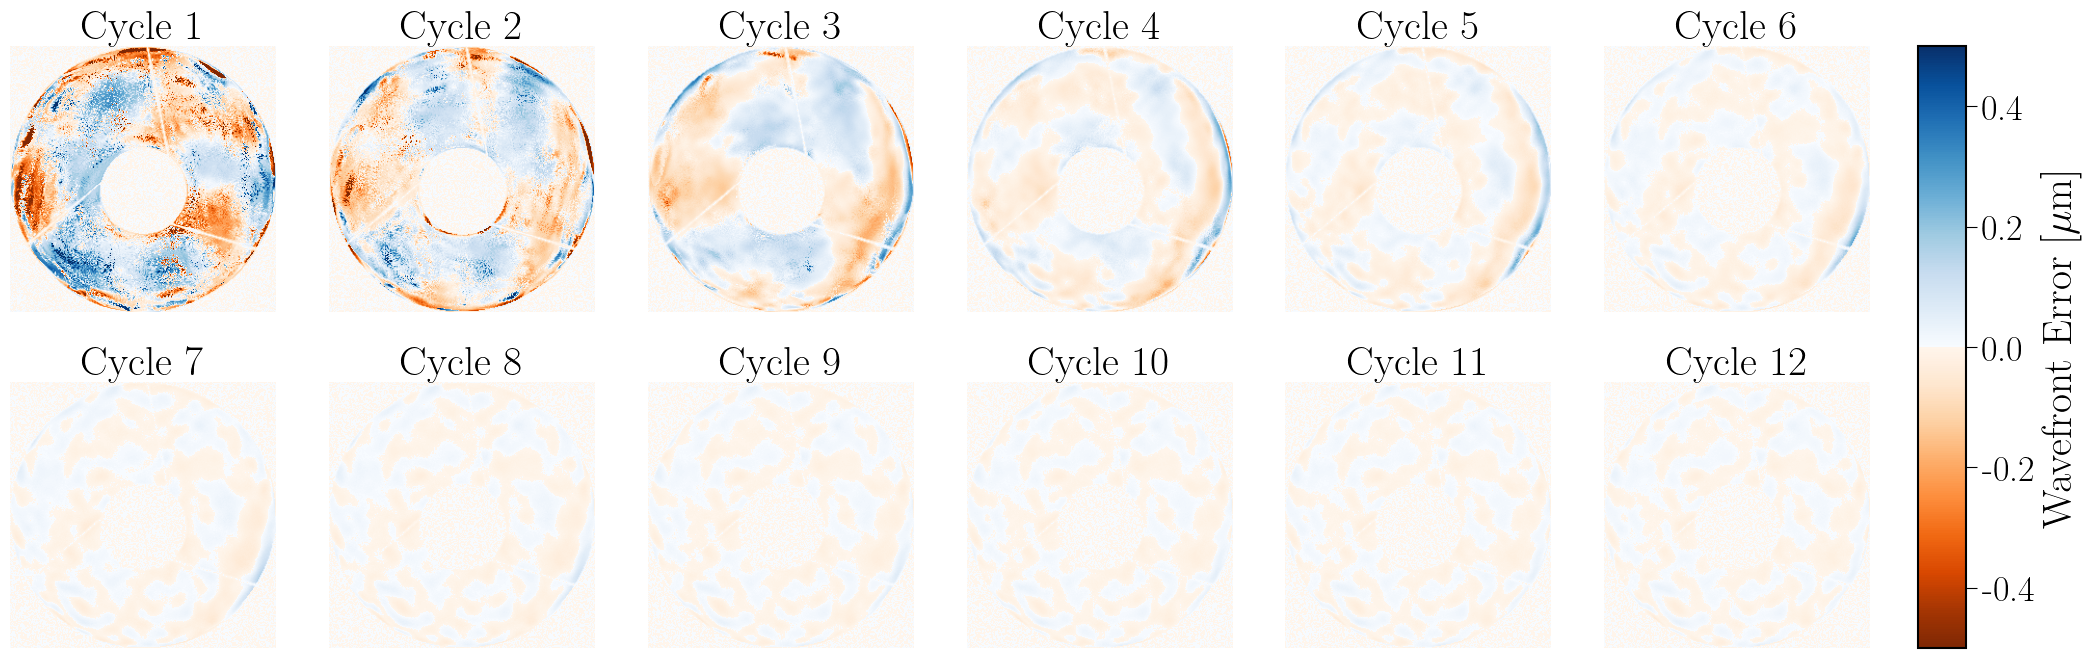

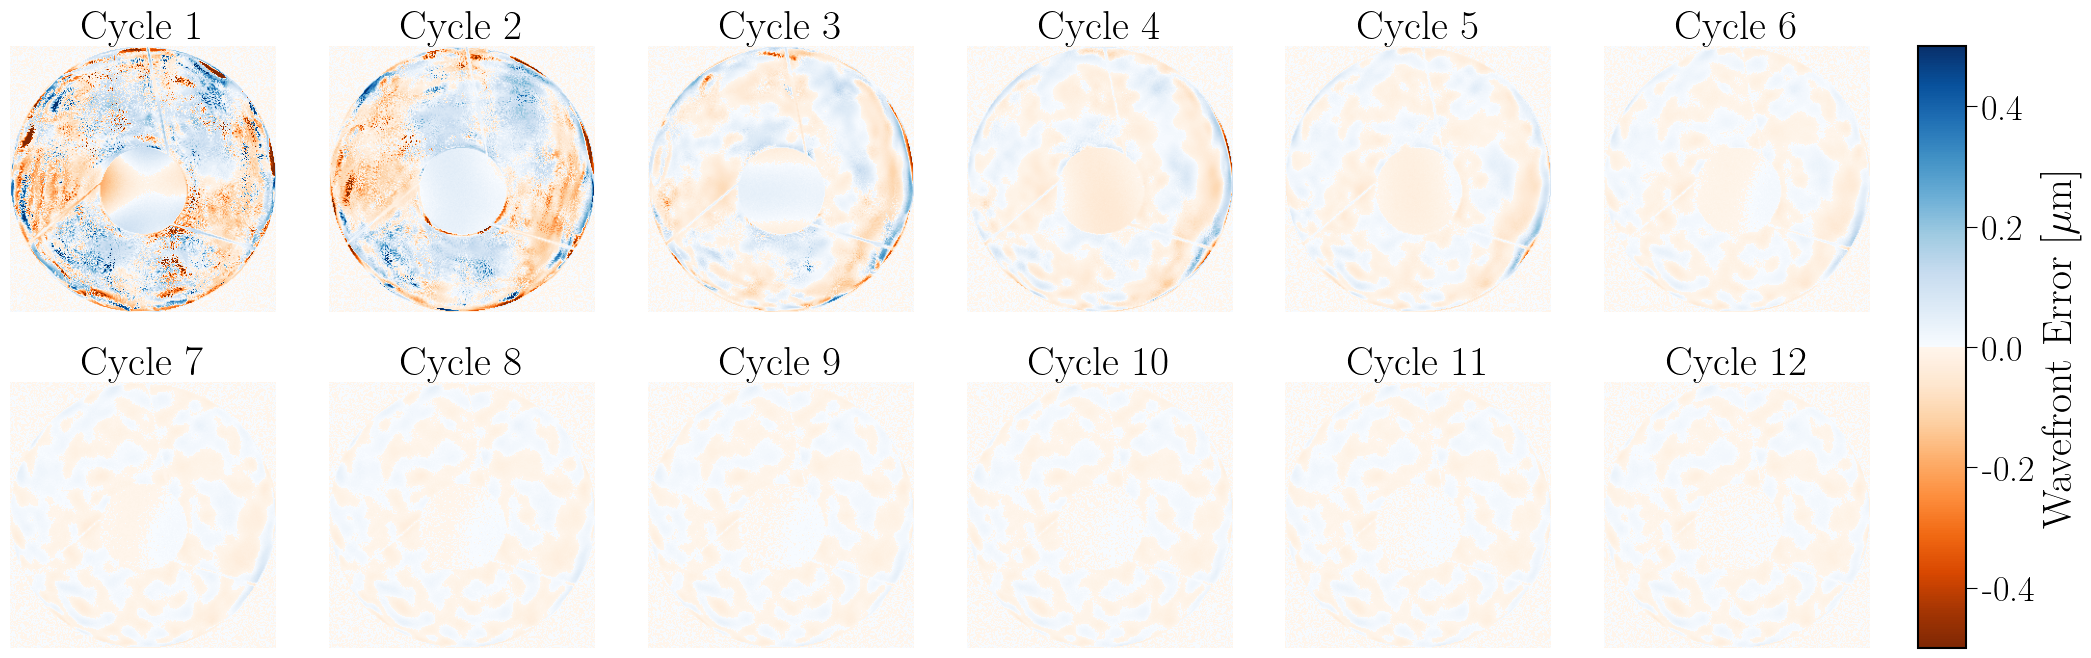

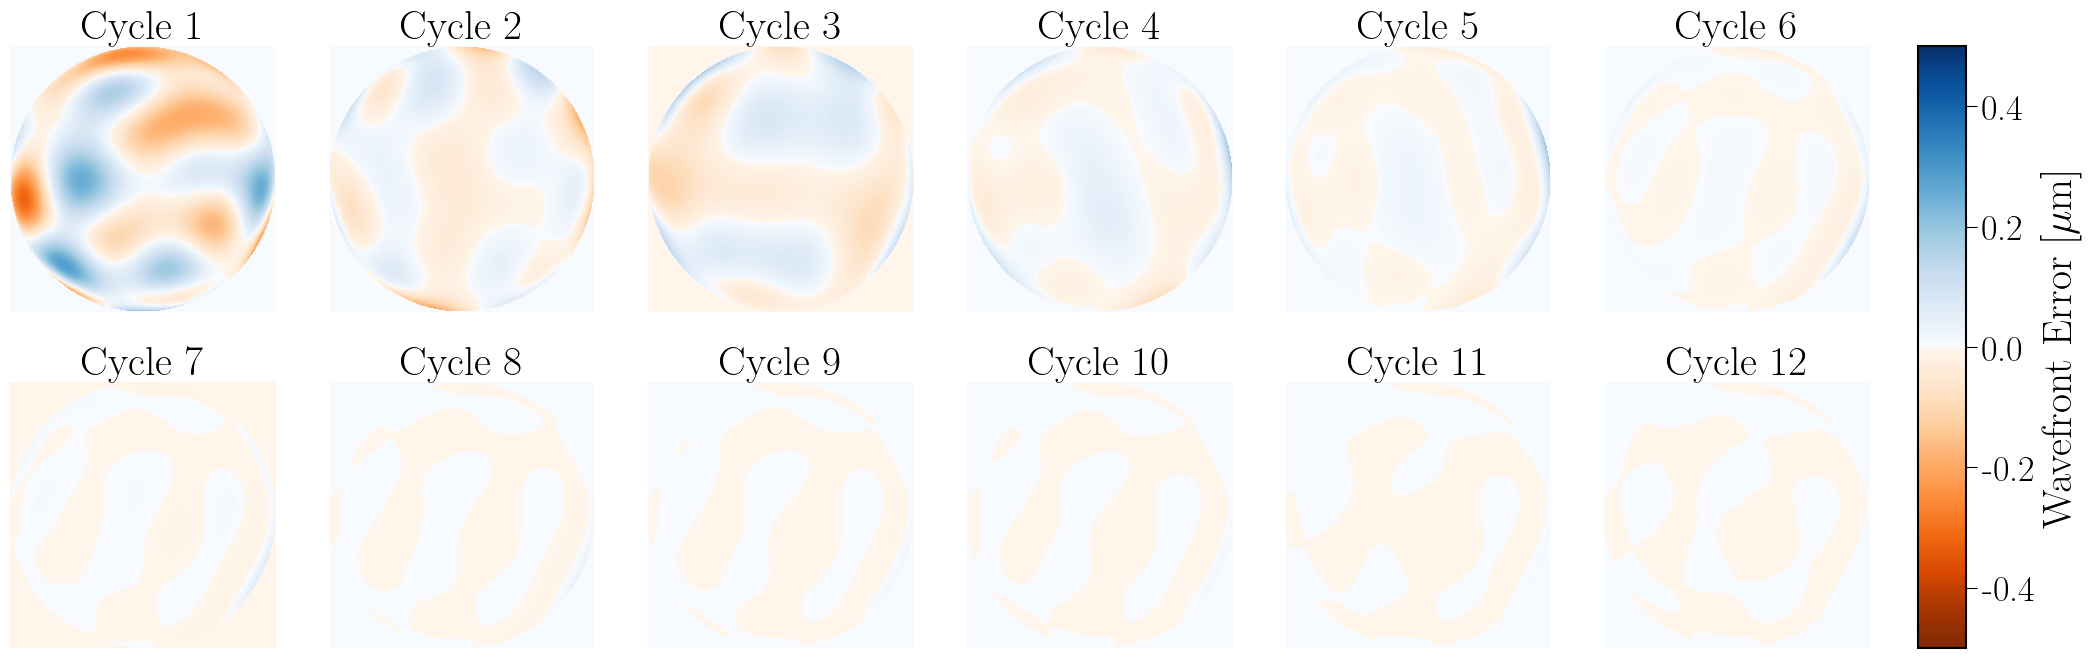

In [128]:

text_fontsize = 30

vmax=0.5

rows = 2
cols = 6
fig, ax =  plt.subplots(rows, cols, figsize=(24,8))
for idx in range(args['total_cycles']):

    ax_y = np.int64(idx%cols)
    ax_x = np.int64(idx//cols)

    im = ax[ax_x, ax_y].imshow(WFE_list[idx][0], cmap=newcmp, vmax=vmax, vmin=-vmax)
    ax[ax_x, ax_y].axis('off')
    ax[ax_x, ax_y].set_title('Cycle %d' % (idx+1), fontsize=text_fontsize)

cax = fig.add_axes([
    ax[1,5].get_position().x1+0.02,
    ax[1,5].get_position().y0,
    0.02,
    ax[0,5].get_position().y1-ax[1,5].get_position().y0
])
cbar = fig.colorbar(im, cax=cax)
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=26, direction="out")
cbar.set_label(r'Wavefront Error [$\mu$m]', fontsize=text_fontsize)


# plt.tight_layout()
if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'Cycle_evolution_parametric.pdf'),
        bbox_inches='tight',
        dpi=300
    )
plt.show()


vmax=0.5
rows = 2
cols = 6
fig, ax =  plt.subplots(rows, cols, figsize=(24,8))
for idx in range(args['total_cycles']):

    ax_y = np.int64(idx%cols)
    ax_x = np.int64(idx//cols)

    im = ax[ax_x, ax_y].imshow(param_opd_maps_GT - WFE_list[idx][0], cmap=newcmp, vmax=vmax, vmin=-vmax)
    ax[ax_x, ax_y].axis('off')
    ax[ax_x, ax_y].set_title('Cycle %d' % (idx+1), fontsize=text_fontsize)

cax = fig.add_axes([
    ax[1,5].get_position().x1+0.02,
    ax[1,5].get_position().y0,
    0.02,
    ax[0,5].get_position().y1-ax[1,5].get_position().y0
])
cbar = fig.colorbar(im, cax=cax)
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=26, direction="out")
cbar.set_label(r'Wavefront Error [$\mu$m]', fontsize=text_fontsize)


# plt.tight_layout()
if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'Cycle_evolution_parametric_error.pdf'),
        bbox_inches='tight',
        dpi=300
    )
plt.show()


vmax=0.5
rows = 2
cols = 6
fig, ax =  plt.subplots(rows, cols, figsize=(24,8))
for idx in range(args['total_cycles']):
    
    ax_y = np.int64(idx%cols)
    ax_x = np.int64(idx//cols)

    im = ax[ax_x, ax_y].imshow(WFE_non_param_list[idx][0], cmap=newcmp, vmax=vmax, vmin=-vmax)
    ax[ax_x, ax_y].axis('off')
    ax[ax_x, ax_y].set_title('Cycle %d' % (idx+1), fontsize=text_fontsize)

cax = fig.add_axes([
    ax[1,5].get_position().x1+0.02,
    ax[1,5].get_position().y0,
    0.02,
    ax[0,5].get_position().y1-ax[1,5].get_position().y0
])
cbar = fig.colorbar(im, cax=cax)
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=26, direction="out")
cbar.set_label(r'Wavefront Error [$\mu$m]', fontsize=text_fontsize)


# plt.tight_layout()
if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'Cycle_evolution_NonParametric.pdf'),
        bbox_inches='tight',
        dpi=300
    )
plt.show()


vmax=0.5
rows = 2
cols = 6
fig, ax =  plt.subplots(rows, cols, figsize=(24,8))
for idx in range(args['total_cycles']):
    
    ax_y = np.int64(idx%cols)
    ax_x = np.int64(idx//cols)

    im = ax[ax_x, ax_y].imshow(WFE_proj_non_param_list[idx][0], cmap=newcmp, vmax=vmax, vmin=-vmax)
    ax[ax_x, ax_y].axis('off')
    ax[ax_x, ax_y].set_title('Cycle %d' % (idx+1), fontsize=text_fontsize)

cax = fig.add_axes([
    ax[1,5].get_position().x1+0.02,
    ax[1,5].get_position().y0,
    0.02,
    ax[0,5].get_position().y1-ax[1,5].get_position().y0
])
cbar = fig.colorbar(im, cax=cax)
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=26, direction="out")
cbar.set_label(r'Wavefront Error [$\mu$m]', fontsize=text_fontsize)


# plt.tight_layout()
if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'Cycle_evolution_NonParametric_afterProj.pdf'),
        bbox_inches='tight',
        dpi=300
    )
plt.show()


vmax=0.5
rows = 2
cols = 6
fig, ax =  plt.subplots(rows, cols, figsize=(24,8))
for idx in range(args['total_cycles']):
    
    ax_y = np.int64(idx%cols)
    ax_x = np.int64(idx//cols)

    im = ax[ax_x, ax_y].imshow(WFE_non_param_list[idx][0] - WFE_proj_non_param_list[idx][0], cmap=newcmp, vmax=vmax, vmin=-vmax)
    ax[ax_x, ax_y].axis('off')
    ax[ax_x, ax_y].set_title('Cycle %d' % (idx+1), fontsize=text_fontsize)

cax = fig.add_axes([
    ax[1,5].get_position().x1+0.02,
    ax[1,5].get_position().y0,
    0.02,
    ax[0,5].get_position().y1-ax[1,5].get_position().y0
])
cbar = fig.colorbar(im, cax=cax)
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=26, direction="out")
cbar.set_label(r'Wavefront Error [$\mu$m]', fontsize=text_fontsize)


# plt.tight_layout()
if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'Cycle_evolution_NonParametric_residualAfterProj.pdf'),
        bbox_inches='tight',
        dpi=300
    )
plt.show()


## Joint WFE plots

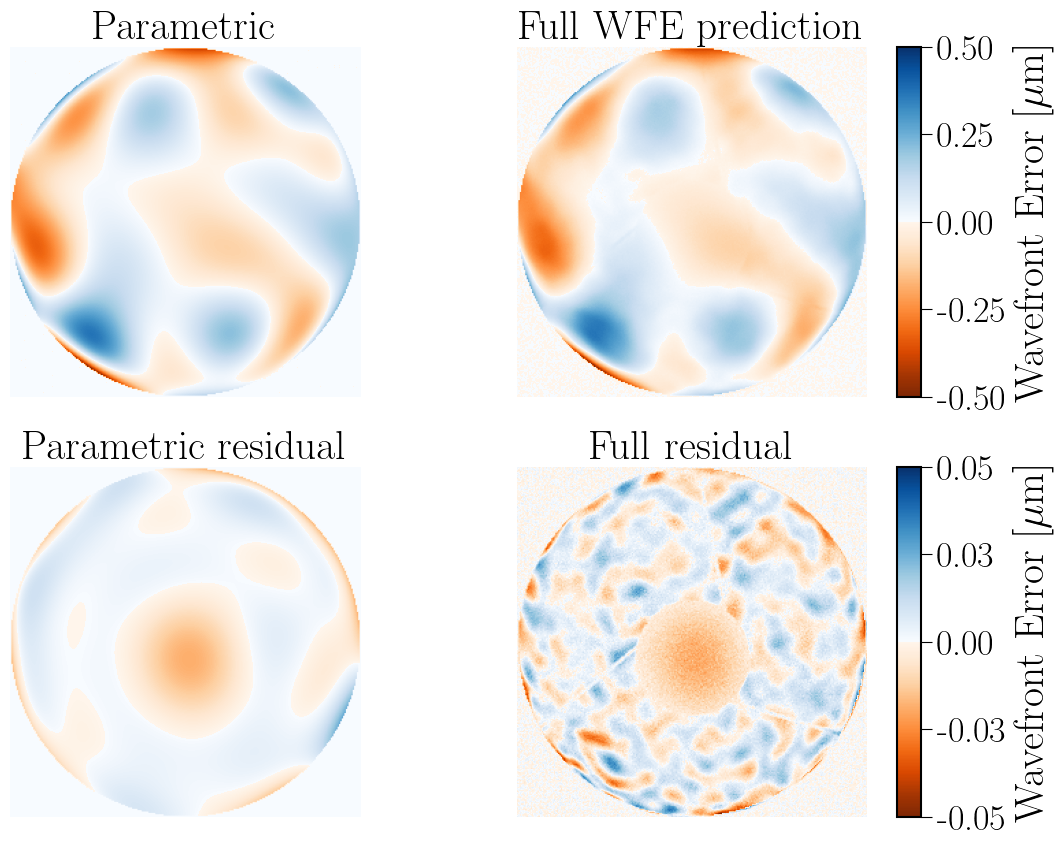

In [175]:
param_opd_map = WFE_list[11][0]
nonparam_opd_maps = WFE_proj_non_param_list[11][0]
full_opd_map = WFE_proj_non_param_list[11][0] + WFE_list[11][0]
# param_opd_maps_GT

vmax = 0.5
vmax_res = 0.05
vmax_nonParam = 0.05

fig, ax = plt.subplots(2,2,figsize=(12,10))
cbar_ticks_size = 18

im_list = []

im_list.append(ax[0][0].imshow(param_opd_map, cmap=newcmp, vmax=vmax, vmin=-vmax))
ax[0][0].set_title('Parametric', fontsize=text_fontsize)
ax[0][0].axis('off')


im_list.append(ax[0][1].imshow(full_opd_map, cmap=newcmp, vmax=vmax, vmin=-vmax))
ax[0][1].set_title('Full WFE prediction', fontsize=text_fontsize)
ax[0][1].axis('off')


im_list.append(ax[1][0].imshow(param_opd_maps_GT - param_opd_map,cmap=newcmp, vmax=vmax_res, vmin=-vmax_res))
ax[1][0].set_title('Parametric residual', fontsize=text_fontsize)
ax[1][0].axis('off')

im_list.append(ax[1][1].imshow(param_opd_maps_GT - full_opd_map,cmap=newcmp, vmax=vmax_res, vmin=-vmax_res))
ax[1][1].set_title('Full residual', fontsize=text_fontsize)
ax[1][1].axis('off')


cax = fig.add_axes([
    ax[0,1].get_position().x1+0.025,
    ax[0,1].get_position().y0,
    0.02,
    ax[0,1].get_position().y1-ax[0,1].get_position().y0
])
cbar = fig.colorbar(im_list[1], cax=cax)
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=26, direction="out")
cbar.set_label(r'Wavefront Error [$\mu$m]', fontsize=text_fontsize)


cax = fig.add_axes([
    ax[1,1].get_position().x1+0.025,
    ax[1,1].get_position().y0,
    0.02,
    ax[1,1].get_position().y1-ax[1,1].get_position().y0
])
cbar = fig.colorbar(im_list[3], cax=cax)
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=26, direction="out")
cbar.set_label(r'Wavefront Error [$\mu$m]', fontsize=text_fontsize)

if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'WFE_final_12_cycles_v0.pdf'),
        bbox_inches='tight',
        dpi=200
    )

plt.show()


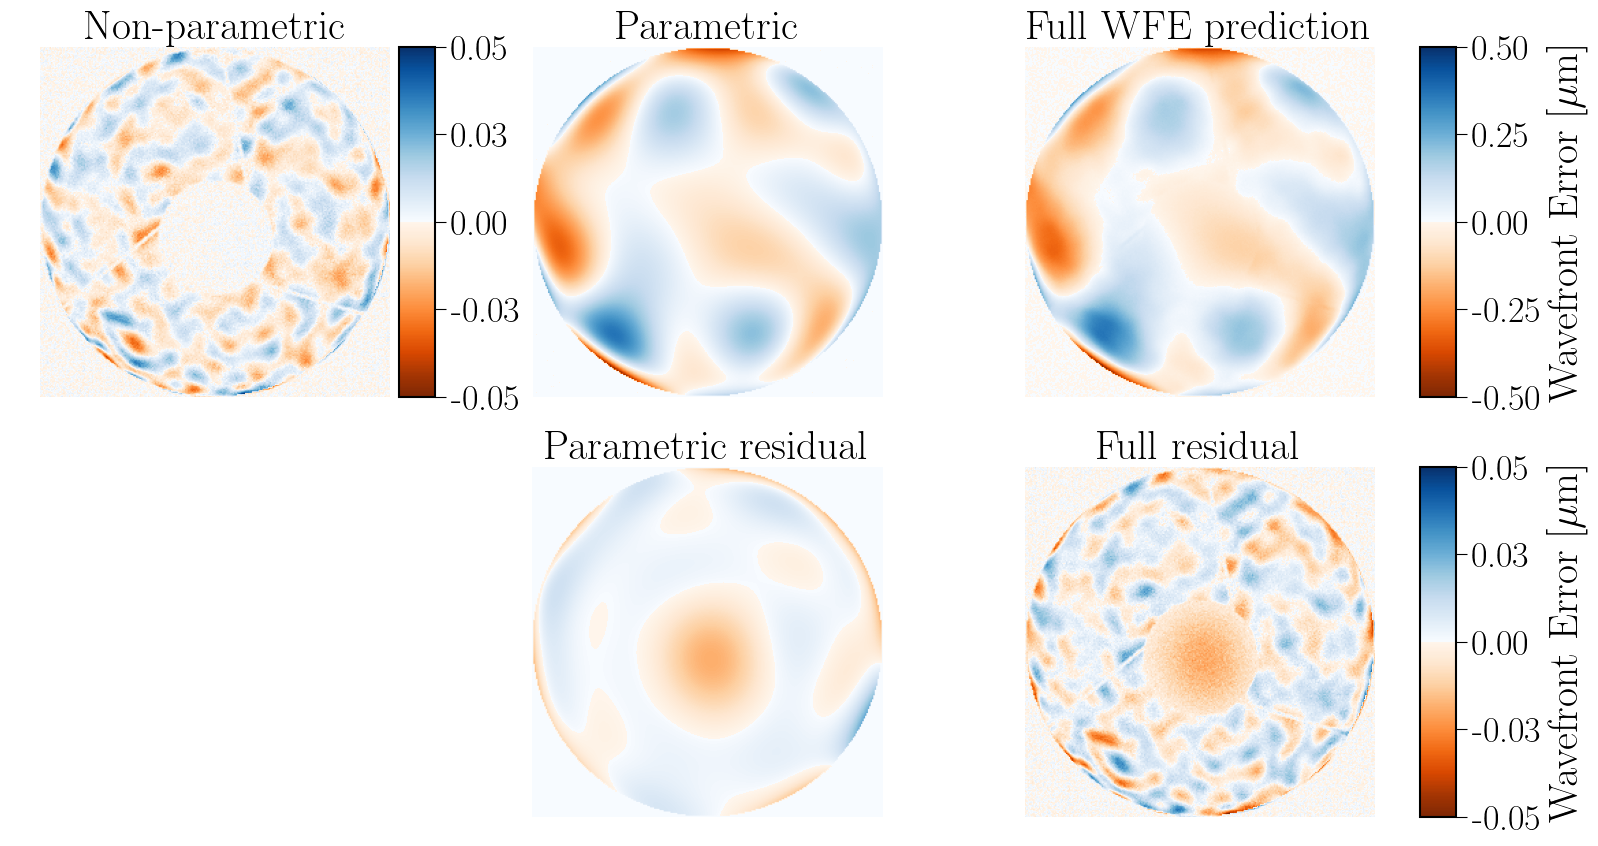

In [166]:
param_opd_map = WFE_list[11][0]
nonparam_opd_maps = WFE_proj_non_param_list[11][0]
full_opd_map = WFE_proj_non_param_list[11][0] + WFE_list[11][0]
# param_opd_maps_GT

vmax = 0.5
vmax_res = 0.05
vmax_nonParam = 0.05

fig, ax = plt.subplots(2,3,figsize=(18,10))
cbar_ticks_size = 18

im_list = []

im_list.append(ax[0][0].imshow(nonparam_opd_maps, cmap=newcmp, vmax=vmax_nonParam, vmin=-vmax_nonParam))
ax[0][0].set_title('Non-parametric', fontsize=text_fontsize)
ax[0][0].axis('off')

im_list.append(ax[0][1].imshow(param_opd_map, cmap=newcmp, vmax=vmax, vmin=-vmax))
ax[0][1].set_title('Parametric', fontsize=text_fontsize)
ax[0][1].axis('off')

im_list.append(ax[0][2].imshow(full_opd_map, cmap=newcmp, vmax=vmax, vmin=-vmax))
ax[0][2].set_title('Full WFE prediction', fontsize=text_fontsize)
ax[0][2].axis('off')


im_list.append(0)
# im_list.append(ax[1][0].imshow(param_opd_maps_GT,cmap=newcmp, vmax=vmax, vmin=-vmax))
# ax[1][0].set_title('Ground truth WFE', fontsize=text_fontsize)
ax[1][0].axis('off')

im_list.append(ax[1][1].imshow(param_opd_maps_GT - param_opd_map,cmap=newcmp, vmax=vmax_res, vmin=-vmax_res))
ax[1][1].set_title('Parametric residual', fontsize=text_fontsize)
ax[1][1].axis('off')

im_list.append(ax[1][2].imshow(param_opd_maps_GT - full_opd_map,cmap=newcmp, vmax=vmax_res, vmin=-vmax_res))
ax[1][2].set_title('Full residual', fontsize=text_fontsize)
ax[1][2].axis('off')


cax = fig.add_axes([
    ax[0,2].get_position().x1+0.025,
    ax[0,2].get_position().y0,
    0.02,
    ax[0,2].get_position().y1-ax[0,2].get_position().y0
])
cbar = fig.colorbar(im_list[2], cax=cax)
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=26, direction="out")
cbar.set_label(r'Wavefront Error [$\mu$m]', fontsize=text_fontsize)


cax = fig.add_axes([
    ax[1,2].get_position().x1+0.025,
    ax[1,2].get_position().y0,
    0.02,
    ax[1,2].get_position().y1-ax[1,2].get_position().y0
])
cbar = fig.colorbar(im_list[5], cax=cax)
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=26, direction="out")
cbar.set_label(r'Wavefront Error [$\mu$m]', fontsize=text_fontsize)

cax = fig.add_axes([
    ax[0,0].get_position().x1+0.005,
    ax[0,0].get_position().y0,
    0.02,
    ax[0,0].get_position().y1-ax[0,0].get_position().y0
])
cbar = fig.colorbar(im_list[0], cax=cax)
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=26, direction="out")
# cbar.set_label(r'Wavefront Error [$\mu$m]', fontsize=text_fontsize)

if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'WFE_final_12_cycles_v1.pdf'),
        bbox_inches='tight',
        dpi=200
    )

plt.show()


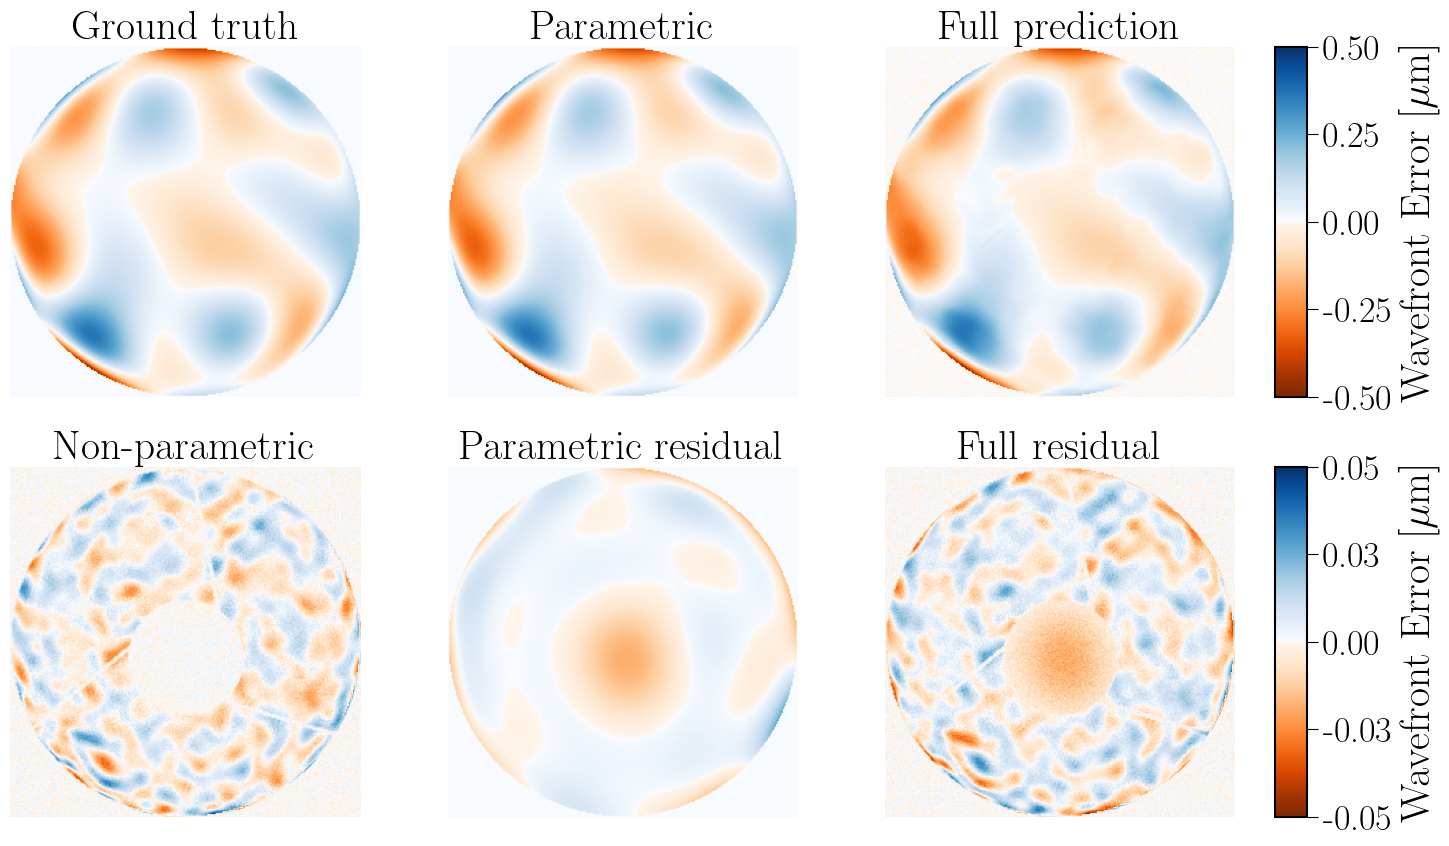

In [173]:
param_opd_map = WFE_list[11][0]
nonparam_opd_maps = WFE_proj_non_param_list[11][0]
full_opd_map = WFE_proj_non_param_list[11][0] + WFE_list[11][0]
# param_opd_maps_GT

vmax = 0.5
vmax_res = 0.05
vmax_nonParam = 0.05

fig, ax = plt.subplots(2,3,figsize=(16,10))
cbar_ticks_size = 18

im_list = []

# im_list.append(0)
im_list.append(ax[0][0].imshow(param_opd_maps_GT,cmap=newcmp, vmax=vmax, vmin=-vmax))
ax[0][0].set_title('Ground truth', fontsize=text_fontsize)
ax[0][0].axis('off')



im_list.append(ax[0][1].imshow(param_opd_map, cmap=newcmp, vmax=vmax, vmin=-vmax))
ax[0][1].set_title('Parametric', fontsize=text_fontsize)
ax[0][1].axis('off')

im_list.append(ax[0][2].imshow(full_opd_map, cmap=newcmp, vmax=vmax, vmin=-vmax))
ax[0][2].set_title('Full prediction', fontsize=text_fontsize)
ax[0][2].axis('off')

im_list.append(ax[1][0].imshow(nonparam_opd_maps, cmap=newcmp, vmax=vmax_res, vmin=-vmax_res))
ax[1][0].set_title('Non-parametric', fontsize=text_fontsize)
ax[1][0].axis('off')


im_list.append(ax[1][1].imshow(param_opd_maps_GT - param_opd_map,cmap=newcmp, vmax=vmax_res, vmin=-vmax_res))
ax[1][1].set_title('Parametric residual', fontsize=text_fontsize)
ax[1][1].axis('off')

im_list.append(ax[1][2].imshow(param_opd_maps_GT - full_opd_map,cmap=newcmp, vmax=vmax_res, vmin=-vmax_res))
ax[1][2].set_title('Full residual', fontsize=text_fontsize)
ax[1][2].axis('off')


cax = fig.add_axes([
    ax[0,2].get_position().x1+0.025,
    ax[0,2].get_position().y0,
    0.02,
    ax[0,2].get_position().y1-ax[0,2].get_position().y0
])
cbar = fig.colorbar(im_list[2], cax=cax)
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=26, direction="out")
cbar.set_label(r'Wavefront Error [$\mu$m]', fontsize=text_fontsize)


cax = fig.add_axes([
    ax[1,2].get_position().x1+0.025,
    ax[1,2].get_position().y0,
    0.02,
    ax[1,2].get_position().y1-ax[1,2].get_position().y0
])
cbar = fig.colorbar(im_list[5], cax=cax)
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=26, direction="out")
cbar.set_label(r'Wavefront Error [$\mu$m]', fontsize=text_fontsize)


if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'WFE_final_12_cycles_v2.pdf'),
        bbox_inches='tight',
        dpi=200
    )

plt.show()


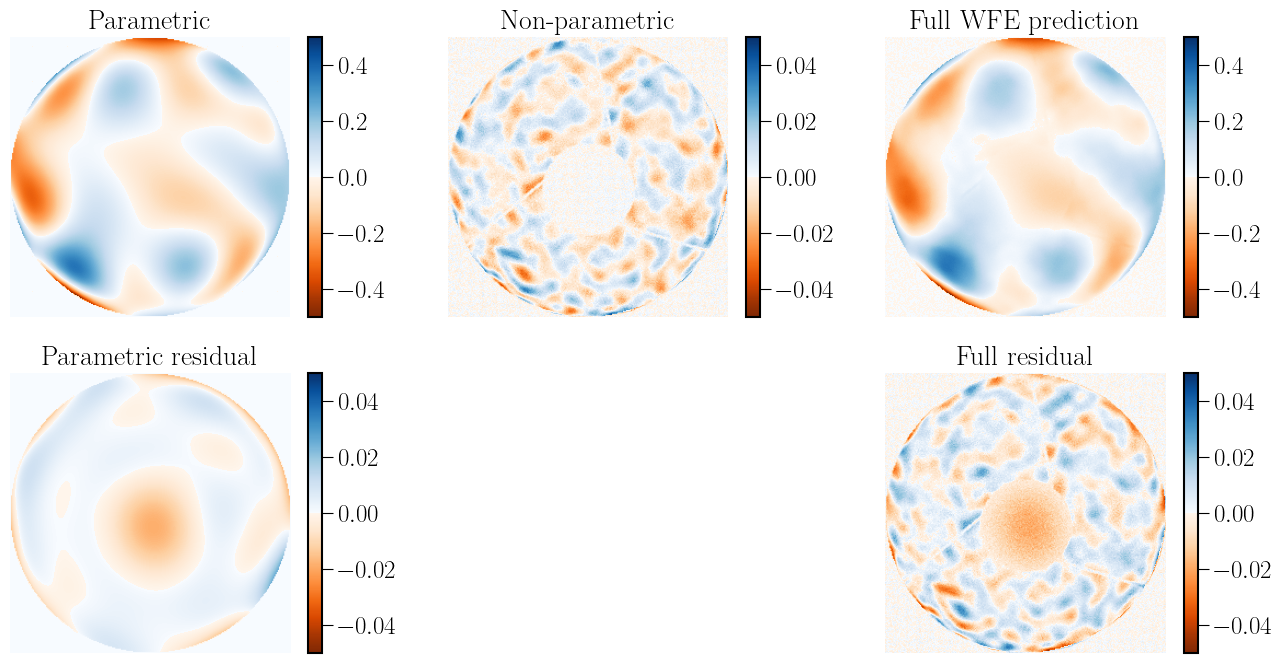

In [144]:

param_opd_map = WFE_list[11][0]
nonparam_opd_maps = WFE_proj_non_param_list[11][0]
full_opd_map = WFE_proj_non_param_list[11][0] + WFE_list[11][0]



# param_opd_maps_GT

vmax = 0.5
vmax_res = 0.05
vmax_nonParam = 0.05

fig, ax = plt.subplots(2,3,figsize=(16,8))
cbar_ticks_size = 18

im = ax[0][0].imshow(param_opd_map, cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[0][0].set_title('Parametric', fontsize=20)
cbar = plt.colorbar(im,ax=ax[0][0])
cbar.ax.tick_params(labelsize=cbar_ticks_size, direction="out")
ax[0][0].axis('off')

im = ax[0][1].imshow(nonparam_opd_maps, cmap=newcmp, vmax=vmax_res, vmin=-vmax_res)
ax[0][1].set_title('Non-parametric', fontsize=20)
cbar=plt.colorbar(im,ax=ax[0][1])
cbar.ax.tick_params(labelsize=cbar_ticks_size, direction="out")
ax[0][1].axis('off')

im = ax[0][2].imshow(full_opd_map, cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[0][2].set_title('Full WFE prediction', fontsize=20)
cbar=plt.colorbar(im,ax=ax[0][2])
cbar.ax.tick_params(labelsize=cbar_ticks_size, direction="out")
ax[0][2].axis('off')



im = ax[1][0].imshow(param_opd_maps_GT - param_opd_map,cmap=newcmp, vmax=vmax_res, vmin=-vmax_res)
ax[1][0].set_title('Parametric residual', fontsize=20)
cbar = plt.colorbar(im,ax=ax[1][0])
cbar.ax.tick_params(labelsize=cbar_ticks_size, direction="out")
ax[1][0].axis('off')

# im = ax[1][1].imshow(param_opd_maps_GT - nonparam_opd_maps, cmap=newcmp, vmax=vmax_res, vmin=-vmax_res)
# ax[1][1].set_title('Non-parametric residual', fontsize=20)
# cbar=plt.colorbar(im,ax=ax[1][1])
# cbar.ax.tick_params(labelsize=cbar_ticks_size, direction="out")2
ax[1][1].axis('off')

im = ax[1][2].imshow(param_opd_maps_GT - full_opd_map,cmap=newcmp, vmax=vmax_res, vmin=-vmax_res)
ax[1][2].set_title('Full residual', fontsize=20)
cbar=plt.colorbar(im,ax=ax[1][2])
cbar.ax.tick_params(labelsize=cbar_ticks_size, direction="out")
ax[1][2].axis('off')

# plt.savefig('../figures/WFE_final_9_cycles.pdf')
plt.show()




## Individual plots

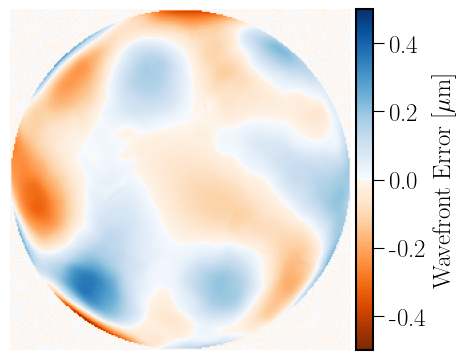

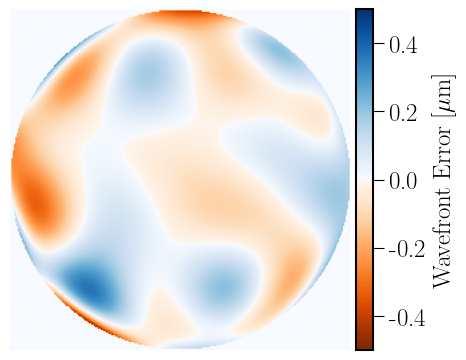

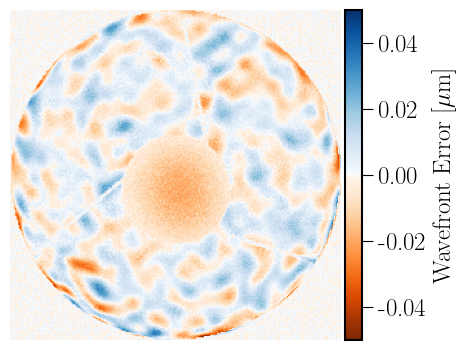

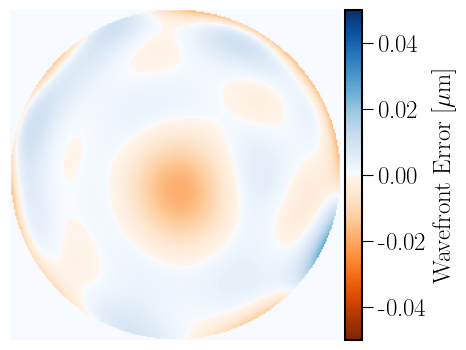

In [129]:


vmax=0.5
cbar_ticks_size = 18

fig = plt.figure(figsize=(5,5))
axs = plt.gca()
plt_im = axs.imshow(full_opd_map, cmap=newcmp, vmax=vmax, vmin=-vmax)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(plt_im, cax=cax)
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=cbar_ticks_size, direction="out")
cbar.set_label(r'Wavefront Error [$\mu$m]')
# axs.set_yticks([]);axs.set_xticks([]) # Use this if you want to have the black border over the image
axs.axis('off')
plt.tight_layout()
if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'full_opd_reconstruction.pdf'),
        bbox_inches='tight',
        dpi=300
    )
plt.show()

fig = plt.figure(figsize=(5,5))
axs = plt.gca()
plt_im = axs.imshow(param_opd_map, cmap=newcmp, vmax=vmax, vmin=-vmax)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(plt_im, cax=cax)
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=cbar_ticks_size, direction="out")
cbar.set_label(r'Wavefront Error [$\mu$m]')
# axs.set_yticks([]);axs.set_xticks([]) # Use this if you want to have the black border over the image
axs.axis('off')
plt.tight_layout()
if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'param_opd_reconstruction.pdf'),
        bbox_inches='tight',
        dpi=300
    )
plt.show()


vmax=0.05
cbar_ticks_size = 18

fig = plt.figure(figsize=(5,5))
axs = plt.gca()
plt_im = axs.imshow(param_opd_maps_GT - full_opd_map, cmap=newcmp, vmax=vmax, vmin=-vmax)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(plt_im, cax=cax)
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=cbar_ticks_size, direction="out")
cbar.set_label(r'Wavefront Error [$\mu$m]')
# axs.set_yticks([]);axs.set_xticks([]) # Use this if you want to have the black border over the image
axs.axis('off')
plt.tight_layout()
if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'full_opd_reconstruction_error.pdf'),
        bbox_inches='tight',
        dpi=300
    )
plt.show()


vmax=0.05
cbar_ticks_size = 18

fig = plt.figure(figsize=(5,5))
axs = plt.gca()
plt_im = axs.imshow(param_opd_maps_GT - param_opd_map, cmap=newcmp, vmax=vmax, vmin=-vmax)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(plt_im, cax=cax)
cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=cbar_ticks_size, direction="out")
cbar.set_label(r'Wavefront Error [$\mu$m]')
# axs.set_yticks([]);axs.set_xticks([]) # Use this if you want to have the black border over the image
axs.axis('off')
plt.tight_layout()
if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'param_opd_reconstruction_error.pdf'),
        bbox_inches='tight',
        dpi=300
    )
plt.show()
